In [2]:
from prototype04_cbcsnrs import CBCSNRsBase, compute_bilby_snr
import numpy as np
import pylab as plt
import bilby
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from datetime import datetime

In [3]:
# Hemanta's code
# only for freqency domain waveform
# 3 detector case
# zero spin
# let geocent time be fixed
# injection is done in zero noise so geocent time wont matter for a single observing run (O1, O2, O3, O4)
def compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, \
                      psi, phase, geocent_time, ra, dec, duration=16.0, sampling_frequency=4096, \
                      waveform_arguments=  dict(waveform_approximant = "TaylorF2", reference_frequency = 30., \
                                                minimum_frequency = 20) ):
    
    mass_1_, mass_2_, luminosity_distance_, \
    theta_jn_, psi_, phase_, ra_, dec_ = np.array([mass_1]).reshape(-1), np.array([mass_2]).reshape(-1), \
                                        np.array([luminosity_distance]).reshape(-1), np.array([theta_jn]).reshape(-1), \
                                        np.array([psi]).reshape(-1), np.array([phase]).reshape(-1), \
                                        np.array([ra]).reshape(-1), np.array([dec]).reshape(-1)
    
    bilby.core.utils.logger.disabled = True
    np.random.seed(88170235)
    nsamples = np.size(mass_1_)
    
    # initialize interferometer object
    # it is ideal to initialized it outside the for loop
    waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration,
            sampling_frequency=sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
            waveform_arguments=waveform_arguments,)
    
    ifos_ = bilby.gw.detector.InterferometerList(["L1", "H1", "V1"])
    ifos_.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=geocent_time - 2,
    )
    
    opt_snr0 = []
    opt_snr1 = []
    opt_snr2 = []
    # f_max=4096/2  
    for i in range(nsamples):
        ifos = ifos_
        injection_parameters = dict(mass_1=mass_1_[i],mass_2=mass_2_[i],a_1=0.,a_2=0.,tilt_1=0.,tilt_2=0.,phi_12=0.,\
                                    phi_jl=0.,luminosity_distance=luminosity_distance_[i],theta_jn=theta_jn_[i],psi=psi_[i], \
                                    phase=phase_[i],geocent_time=geocent_time,ra=ra_[i],dec=dec_[i])
        ifos.inject_signal(
            waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
        );
        
        opt_snr0.append(ifos[0].meta_data['optimal_SNR'])
        opt_snr1.append(ifos[1].meta_data['optimal_SNR'])
        opt_snr2.append(ifos[2].meta_data['optimal_SNR'])
        
    opt_snr0,opt_snr1,opt_snr2 = np.array(opt_snr0),np.array(opt_snr1),np.array(opt_snr2)
    opt_snr_net = np.sqrt(opt_snr0**2 + opt_snr1**2 + opt_snr2**2)

    return(np.array([opt_snr0, opt_snr1, opt_snr2, opt_snr_net]))

In [4]:
# Otto's code
# Function for computing bilby SNRs
def compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=4.0, sampling_frequency=4096, waveform_arguments=  dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"]):
    # Set the duration and sampling frequency of the data segment that we're
    # going to inject the signal into
    # Specify the output directory and the name of the simulation.
    bilby.core.utils.logger.disabled = True
    # Set up a random seed for result reproducibility. 
    np.random.seed(88170235)
    # We are going to inject a binary black hole waveform.  We first establish a
    # dictionary of parameters that includes all of the different waveform
    # parameters, including masses of the two black holes (mass_1, mass_2),
    # spins of both black holes (a, tilt, phi), etc.
    injection_parameters = dict(
        mass_1=mass_1,
        mass_2=mass_2,
        a_1=a_1,
        a_2=a_2,
        tilt_1=tilt_1,
        tilt_2=tilt_2,
        phi_12=phi_12,
        phi_jl=phi_jl,
        luminosity_distance=luminosity_distance,
        theta_jn=theta_jn,
        psi=psi,
        phase=phase,
        geocent_time=geocent_time,
        ra=ra,
        dec=dec
    )
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    # the generator will convert all the parameters
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
    )
    # Set up interferometers.  In this case we'll use two interferometers
    # (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
    # sensitivity
    ifos = bilby.gw.detector.InterferometerList(list_of_detectors)
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - 2,
    )
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
    );
    network_optimal_snr_squared = 0
    for i in range(len(ifos)):
        single_detector_optimal_snr = ifos[i].meta_data['optimal_SNR']
        # Sum in quadrature
        network_optimal_snr_squared = network_optimal_snr_squared + single_detector_optimal_snr**2
    network_optimal_snr = np.sqrt(network_optimal_snr_squared)
    return network_optimal_snr

In [15]:
def interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples, psi=0., phase=0., ra=0., dec=0., geocent_time=1246527184.169434, \
                        waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 30., minimum_frequency = 20)):
    # preferably: nsamples = 200
    mchirp = np.geomspace(mchirp_min, mchirp_max, nsamples)
    mass_1 = (mchirp*(1+q)**(1/5))/q**(3/5)
    mass_2 = mchirp*q**(2/5)*(1+q)**(1/5)
    
    idx = mass_2>=1. # on the condition that neutron stars cannot be smaller than 1 solar_mass
    mass_1 = mass_1[idx]
    mass_2 = mass_2[idx]
    mtot = mass_1+mass_2
    mchirp = mchirp[idx]
    nsamples = len(mass_1)
    geocent_time = geocent_time
    luminosity_distance =100.*np.ones(nsamples)
    # geocent_time cannot be array here
    theta_jn, psi, phase, ra, dec = iota*np.ones(nsamples), psi*np.ones(nsamples), \
                                        phase*np.ones(nsamples), ra*np.ones(nsamples), dec*np.ones(nsamples)
    
    opt_snr_unscaled = compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, psi, \
                                          phase, geocent_time, ra, dec, duration=16., sampling_frequency=4096, \
                                          waveform_arguments= waveform_arguments)  
    
    A2 = mchirp**(5./6.)
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (Deff2/A2)*opt_snr_unscaled[0]
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (Deff2/A2)*opt_snr_unscaled[1]
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (Deff2/A2)*opt_snr_unscaled[2]
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,mchirp,L1snr_,H1snr_,V1snr_,net_snr] ))

In [23]:
# without putting constraint on mass_2, so mass_2 can be <1solar_mass 
def interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples, psi=0., phase=0., ra=0., dec=0., geocent_time=1246527184.169434, \
                        waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 30., minimum_frequency = 20)):
    # preferably: nsamples = 200
    mchirp = np.geomspace(mchirp_min, mchirp_max, nsamples)
    mass_1 = (mchirp*(1+q)**(1/5))/q**(3/5)
    mass_2 = mchirp*q**(2/5)*(1+q)**(1/5)
    mtot = mass_1+mass_2
    geocent_time = geocent_time
    luminosity_distance =100.*np.ones(nsamples)
    # geocent_time cannot be array here
    theta_jn, psi, phase, ra, dec = iota*np.ones(nsamples), psi*np.ones(nsamples), \
                                        phase*np.ones(nsamples), ra*np.ones(nsamples), dec*np.ones(nsamples)
    
    opt_snr_unscaled = compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, psi, \
                                          phase, geocent_time, ra, dec, duration=16., sampling_frequency=4096, \
                                          waveform_arguments= waveform_arguments)  
    
    A2 = mchirp**(5./6.)
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (Deff2/A2)*opt_snr_unscaled[0]
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (Deff2/A2)*opt_snr_unscaled[1]
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (Deff2/A2)*opt_snr_unscaled[2]
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,mchirp,L1snr_,H1snr_,V1snr_,net_snr] ))

* Below, mchirp_min is chosen so that mass_2>1solar_mass at q=0.4
* i avoid high mass as the curve become more difficult to fit

In [25]:
waveform_argument= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20)
table1p0 = interpolation_table(1.,0., 1, 100, 30, waveform_arguments=waveform_argument) #q=0.0
table0p8 = interpolation_table(0.8,0., 1, 100, 30, waveform_arguments=waveform_argument) #q=0.8
table0p6 = interpolation_table(0.6,0., 1, 100, 30, waveform_arguments=waveform_argument) #q=0.6
table0p4 = interpolation_table(0.4,0., 1, 100, 30, waveform_arguments=waveform_argument) #q=0.4

# halfed scaled SNR variation with $M_{tot}$, $\mathcal{M}$ and $m_1$ at three different $q$ (0.1,0.7,0.4)
* halfed scaled SNR = (Deff2/A2)*opt_snr_unscaled

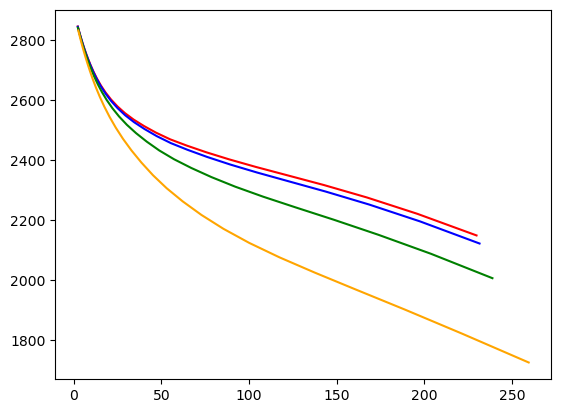

In [26]:
# halfed scaled SNR vs mtot
plt.plot(table1p0[0],table1p0[3], color='red' )
plt.plot(table0p8[0],table0p8[3], color='blue' )
plt.plot(table0p6[0],table0p6[3], color='green' )
plt.plot(table0p4[0],table0p4[3], color='orange' )

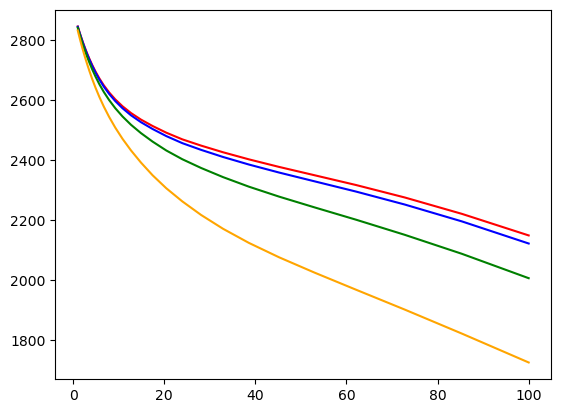

In [27]:
# halfed scaled SNR vs mchirp
plt.plot(table1p0[1],table1p0[3], color='red' )
plt.plot(table0p8[1],table0p8[3], color='blue' )
plt.plot(table0p6[1],table0p6[3], color='green' )
plt.plot(table0p4[1],table0p4[3], color='orange' )

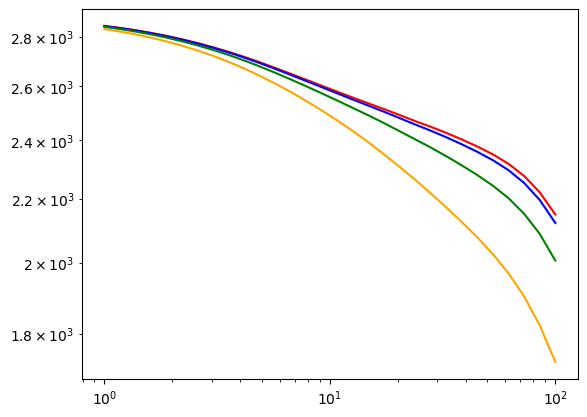

In [28]:
# halfed scaled SNR vs mchirp
plt.loglog(table1p0[1],table1p0[3], color='red' )
plt.loglog(table0p8[1],table0p8[3], color='blue' )
plt.loglog(table0p6[1],table0p6[3], color='green' )
plt.loglog(table0p4[1],table0p4[3], color='orange' )

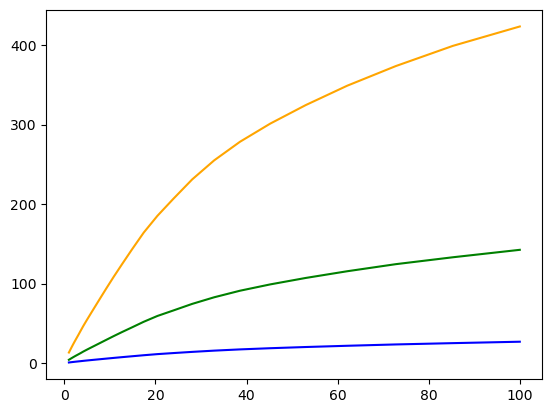

In [29]:
# halfed scaled SNR difference vs mchirp
plt.plot(table0p8[1],table1p0[3]-table0p8[3], color='blue' )
plt.plot(table0p6[1],table1p0[3]-table0p6[3], color='green' )
plt.plot(table0p4[1],table1p0[3]-table0p4[3], color='orange' )

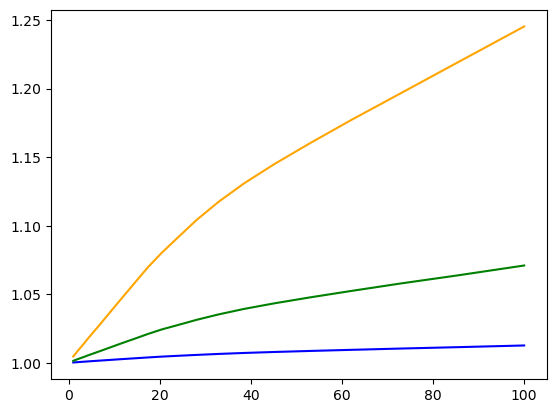

In [30]:
# halfed scaled SNR ratio vs mchirp
plt.plot(table0p8[1],table1p0[3]/table0p8[3], color='blue' )
plt.plot(table0p6[1],table1p0[3]/table0p6[3], color='green' )
plt.plot(table0p4[1],table1p0[3]/table0p4[3], color='orange' )

* half scaled snr variation in TaylorF2 is negligible with mass ratio
* this is not the case for XPHM model

# Comparision with TaylorF2 and IMRPhenomXPHM

In [40]:
waveform_argument= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20)
table1p0 = interpolation_table(1.,0., 1, 100, 30, waveform_arguments=waveform_argument) #q=1.0
table1p0_ = interpolation_table(1.,0., 1, 100, 30) #q=1.0

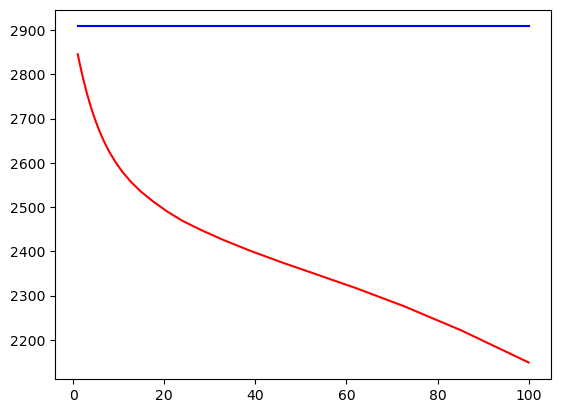

In [41]:
# halfed scaled SNR vs mchirp
plt.plot(table1p0[1],table1p0[3], color='red' )
plt.plot(table1p0_[1],table1p0_[3], color='blue' )

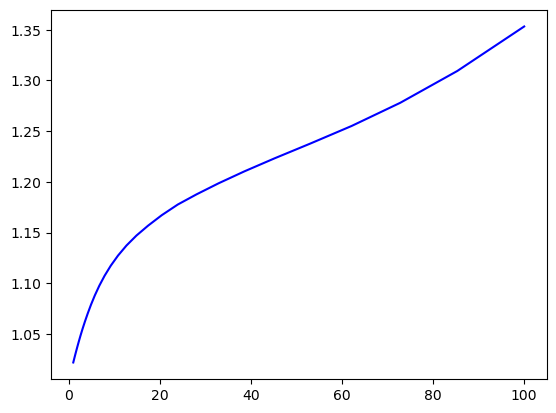

In [42]:
# halfed scaled SNRs vs mchirp
# relative differecne
plt.plot(table1p0_[1],table1p0_[3]/table1p0[3], color='blue' )

* there is no simple function that can replicate this curve
* cubic spline can be use to mimic this curve. Or one can get the distribition in array format.
* SNR vs mchirp curve is depends on mass_ratio
* so, let there be 10 point of mass_ratio for curve fitting
* let the curve be simple shift in SNR, for different detectors.
* otherwise we would need 20*3=60 curve fittings.

# half scaled SNR variation with $\mathcal{M}$ at three different detectors

* first try for q=1

In [68]:
waveform_argument= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20)
table1p0 = interpolation_table(1.0,0., 1, 100, 30, waveform_arguments=waveform_argument) #q=1.0
table1p0_ = interpolation_table(1.0,0., 1, 100, 30) #q=1.0

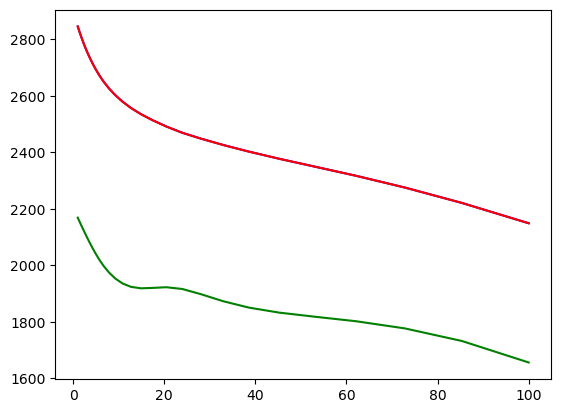

In [59]:
# L1 Vs H1
plt.plot(table1p0[1],table1p0[2], color='blue' )
plt.plot(table1p0[1],table1p0[3], color='red' )
plt.plot(table1p0[1],table1p0[4], color='green')

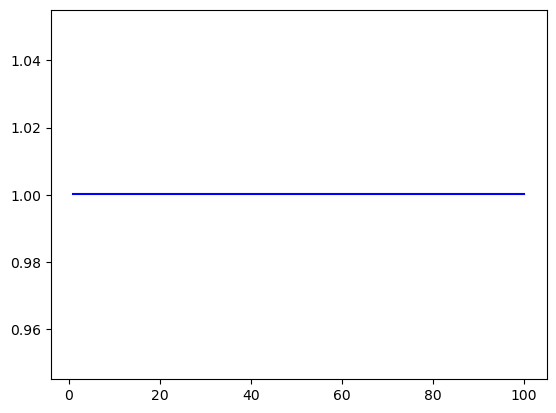

In [60]:
plt.plot(table1p0[1],table1p0[2]/table1p0[3], color='blue' ) #SNR_L1/SNR_H1

In [62]:
# for L1 Vs H1, its just a small shift
table1p0[2]/table1p0[3]

array([1.00007717, 1.00007717, 1.00007717, 1.00007717, 1.00007717,
       1.00007717, 1.00007717, 1.00007717, 1.00007717, 1.00007717,
       1.00007717, 1.00007717, 1.00007717, 1.00007717, 1.00007717,
       1.00007717, 1.00007717, 1.00007717, 1.00007717, 1.00007717,
       1.00007717, 1.00007717, 1.00007717, 1.00007717, 1.00007717,
       1.00007717, 1.00007717, 1.00007717, 1.00007717, 1.00007717])

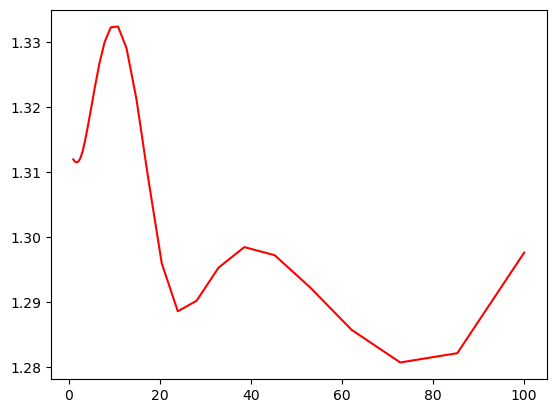

In [69]:
# for L1 Vs V1, its more complicated. I will need interpolation
plt.plot(table1p0[1],table1p0[2]/table1p0[4], color='red' )

In [70]:
ratio1_ = table1p0[2]/table1p0[4]

* check for q=0.5

In [71]:
waveform_argument= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20)
table1p0 = interpolation_table(0.5,0., 1, 100, 30, waveform_arguments=waveform_argument) #q=1.0
table1p0_ = interpolation_table(0.5,0., 1, 100, 30) #q=1.0

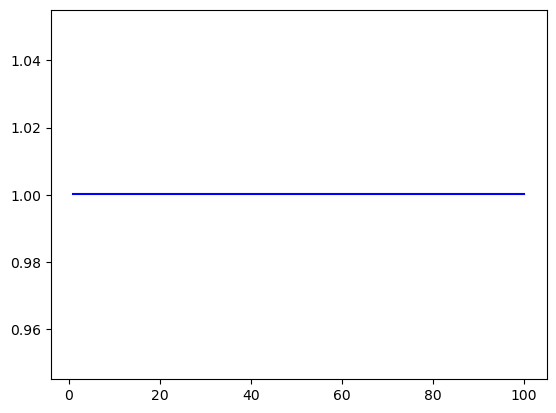

In [72]:
plt.plot(table1p0[1],table1p0[2]/table1p0[3], color='blue' )

In [78]:
table1p0[3]/table1p0[2]

array([0.99992284, 0.99992284, 0.99992284, 0.99992284, 0.99992284,
       0.99992284, 0.99992284, 0.99992284, 0.99992284, 0.99992284,
       0.99992284, 0.99992284, 0.99992284, 0.99992284, 0.99992284,
       0.99992284, 0.99992284, 0.99992284, 0.99992284, 0.99992284,
       0.99992284, 0.99992284, 0.99992284, 0.99992284, 0.99992284,
       0.99992284, 0.99992284, 0.99992284, 0.99992284, 0.99992284])

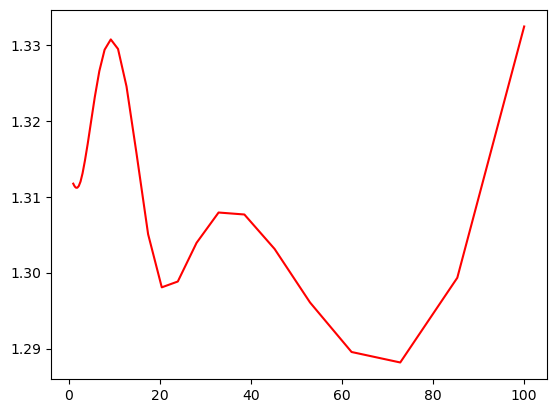

In [73]:
# for L1 Vs V1, its more complicated. I will need interpolation
plt.plot(table1p0[1],table1p0[2]/table1p0[4], color='red' )

In [74]:
ratio2_ = table1p0[2]/table1p0[4]

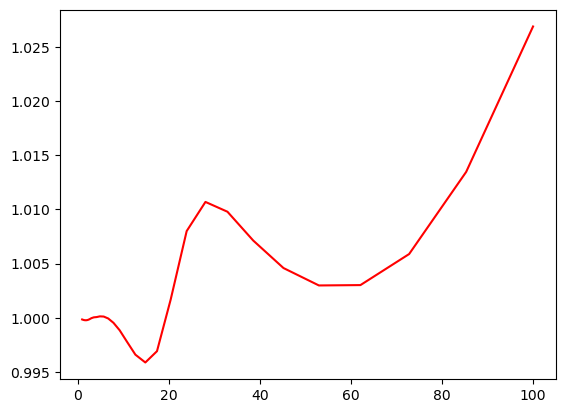

In [77]:
plt.plot(table1p0[1],ratio2_/ratio1_, color='red' ) # q=1 vs q=0.5

* there is no relation between q=1 and q=0.5 curve.
* but H1 = L1*0.99992284
* so we need interpolation table for only L1 and V1

# to find the right interpolation (q=1 case)
* simple interpolation with np.searchsorted first
* compare with cubic spline

In [208]:
# generate the interpolation data first
# without putting constraint on mass_2, so mass_2 can be <1solar_mass 
def interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples, psi=0., phase=0., ra=0., dec=0., geocent_time=1246527184.169434, \
                        waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 30., minimum_frequency = 20)):
    # preferably: nsamples = 200
    mchirp = np.linspace(mchirp_min, mchirp_max, nsamples)
    mass_1 = (mchirp*(1+q)**(1/5))/q**(3/5)
    mass_2 = mchirp*q**(2/5)*(1+q)**(1/5)
    mtot = mass_1+mass_2
    geocent_time = geocent_time
    luminosity_distance =100.*np.ones(nsamples)
    # geocent_time cannot be array here
    theta_jn, psi, phase, ra, dec = iota*np.ones(nsamples), psi*np.ones(nsamples), \
                                        phase*np.ones(nsamples), ra*np.ones(nsamples), dec*np.ones(nsamples)
    
    opt_snr_unscaled = compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, psi, \
                                          phase, geocent_time, ra, dec, duration=16., sampling_frequency=4096, \
                                          waveform_arguments= waveform_arguments)  
    
    A2 = mchirp**(5./6.)
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (Deff2/A2)*opt_snr_unscaled[0]
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (Deff2/A2)*opt_snr_unscaled[1]
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (Deff2/A2)*opt_snr_unscaled[2]
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,mchirp,L1snr_,H1snr_,V1snr_,net_snr] ))

In [209]:
waveform_argument= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20)
table1p0 = interpolation_table(1.,0., 1, 100, 100, waveform_arguments=waveform_argument) #q=0.0

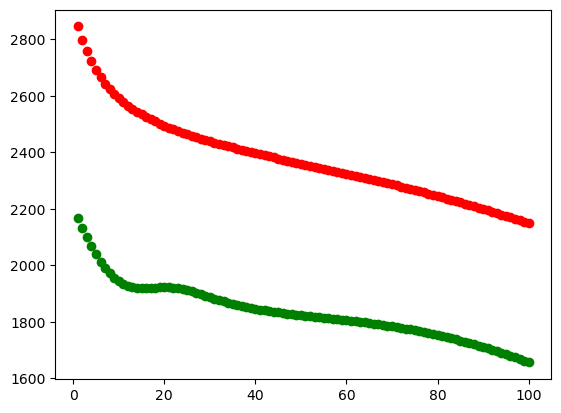

In [210]:
# halfed scaled SNR vs mtot
plt.scatter(table1p0[1],table1p0[2], color='red' )
#plt.scatter(table1p0[1],table1p0[3], color='blue' )
plt.scatter(table1p0[1],table1p0[4], color='green' )

In [211]:
L1V1_table = np.array([table1p0[1], table1p0[2], table1p0[4]]) # ([chirpM, L1, V1])

* now write function for scaling

In [212]:
def scaled_snr_(mass_1, mass_2, iota, snr_table, Dl, psi, geocent_time, ra, dec):
    
    chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    idx = np.searchsorted(snr_table[0],chirp_mass)
    mtot = mass_2+mass_1
    A1 = chirp_mass**(5./6.)
    geocent_time = 1246527184.169434
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*snr_table[1,idx]
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*snr_table[1,idx]*0.99992284
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*snr_table[2,idx]
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,chirp_mass,L1snr_,H1snr_,V1snr_,net_snr] ))

In [213]:
mm1 = 80.
mm2 = 80.
chirpm = ( (mm1*mm2)**(3/5) )/( (mm1+mm2)**(1/5) )

In [214]:
# scaled SNR
snr_ = scaled_snr_(mm1, mm2, 0., L1V1_table, 80., 0., 1246527184.169434, 0., 0.);
print('SNRs: L1={}, H1={}, V1={}, net_snr={}'.format(snr_[2], snr_[3], snr_[4], snr_[5]))

SNRs: L1=792.0655805368992, H1=502.5133515292472, V1=243.3893843518967, net_snr=969.0851070734743


In [204]:
# bilby_snr
snr_ = compute_bilby_snr_(mm1, mm2, 80., 0., 0., 0., 1246527184.169434, 0., 0., duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
print('SNRs: L1={}, H1={}, V1={}, net_snr={}'.format(snr_[0,0], snr_[1,0], snr_[2,0], snr_[3,0]))

SNRs: L1=792.5554186131493, H1=502.82412166120054, V1=243.5137154011366, net_snr=969.6778426291321


In [205]:
# bilby_snr, Otto's code
##compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=4.0, sampling_frequency=4096, waveform_arguments=  dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])
snr_ = compute_bilby_snr(mm1, mm2, 0., 0., 0., 0., 0., 0., 80., 0., \
                         0., 0., 1246527184.169434, 0., 0., duration=16.0, sampling_frequency=4096, \
                         waveform_arguments=  dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., \
                                                   minimum_frequency = 20), \
                         list_of_detectors=["L1", "H1", "V1"])

print('SNRs: net_snr={}'.format(snr_))

SNRs: net_snr=969.6778426291321


In [206]:
# percentage error, geomspace interpolation in chirp_mass
np.abs(965.3484725038635-969.6778426291321)/969.6778426291321*100 #geomspace

0.44647510079535185

In [215]:
# percentage error, linspace interpolation in chirp_mass
np.abs(969.0851070734743-969.6778426291321)/969.6778426291321*100 #linspace

0.06112705989554955

# now comparision 

* optimal orientation and sky location first

In [226]:
# gerneral case, random parameters
nsamples = 100
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = 1.*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [227]:
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], L1V1_table, luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.386492


In [228]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:05.622343


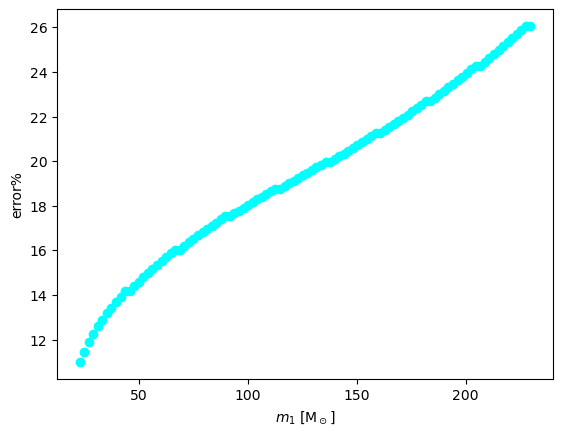

In [229]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

* random orientation and sky location now

In [235]:
# gerneral case, random parameters
nsamples = 100
chirp_mass = np.linspace(10,80,nsamples)
mass_ratio = 1.*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [236]:
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], L1V1_table, luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.841899


In [237]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:07.559298


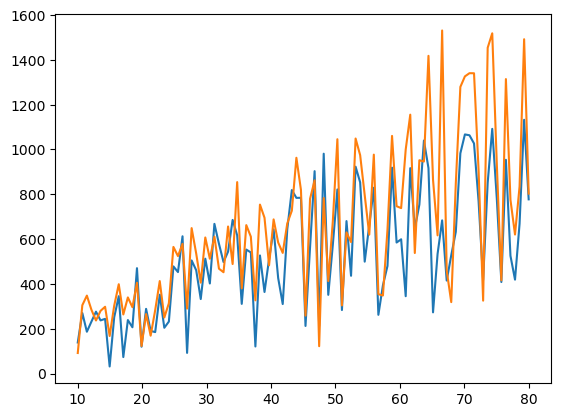

In [238]:
# net snr
plt.plot(chirp_mass,my_snrs[:,3])
plt.plot(chirp_mass,bilby_snrs[:,3])

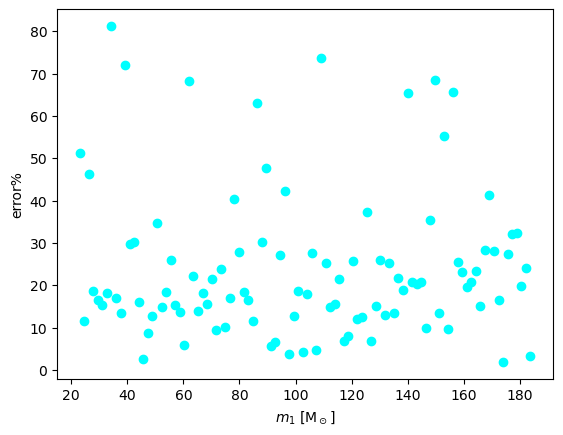

In [239]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()